<a href="https://colab.research.google.com/github/neuralninja27/Image-CLassification-FashionMNIST/blob/main/Image_Classification_on_the_FashionMNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import relevant libraries

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


### Setting up the dataset

In [ ]:
# Setup training and test data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12229185.98it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211291.20it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3896286.38it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20642712.23it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# Check class names in data
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# Check class indices
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
# Check target data format
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
# Check shape of first data sample
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

### Visualize the data

Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

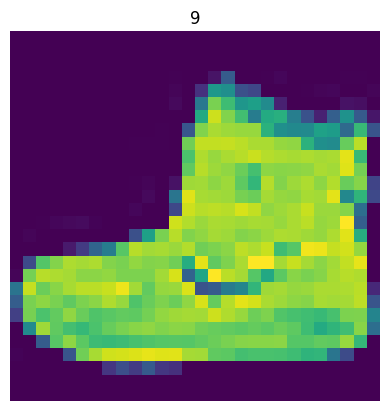

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze());
plt.title(label)
plt.axis(False)

(-0.5, 27.5, 27.5, -0.5)

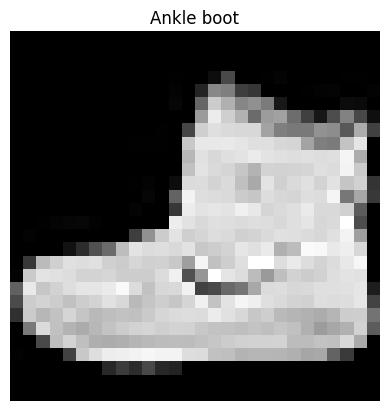

In [ ]:
# View image in grayscale format
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

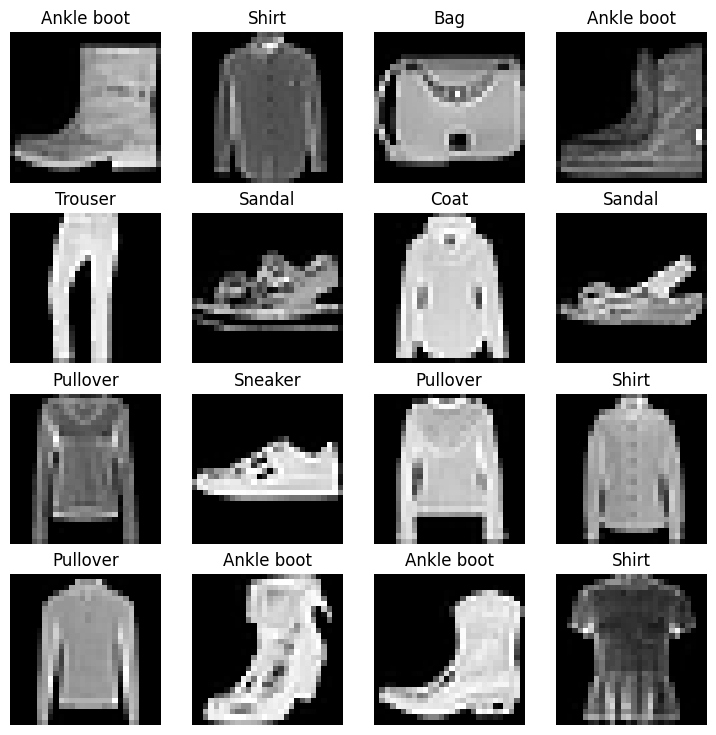

In [ ]:
# Plot more images from the dataset
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

### Prepare DataLoader with PyTorch (turns dataset into an iterable)

In [ ]:
from torch.utils.data import DataLoader

# Setup batch size
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [ ]:
# Check what's inside train_dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


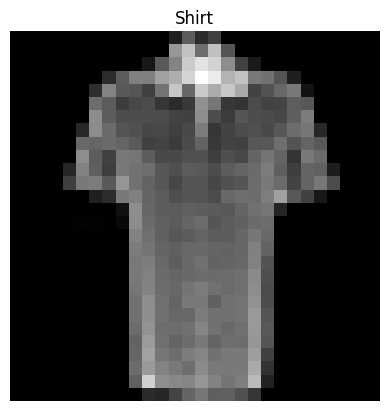

In [ ]:
# Show sample data from dataloader
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [ ]:
# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Building a model using CNNs

In [ ]:
# Create a CNN model
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )
  
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
# Instantiate the CNN model
torch.manual_seed(42)
model = FashionMNISTModel(input_shape=1,
                            output_shape=len(class_names),
                            hidden_units=10).to(device)
model

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [ ]:
# Function to calculate accuracy of model
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Create training and testing functions

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0

  # Put the model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data onto target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()
  
  # Divide total train loss and train acc by length of dataloader
  train_loss /= len(data_loader) # train loss per batch
  train_acc /= len(data_loader) # train acc per batch
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
  

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0

  # Put model imto eval mode
  model.eval()

  # Turn on inference model context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Put data onto the target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred = model(X)

      # Calculate test loss and acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Calculate test loss and acc per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
# Create a function to evaluate the model
from tqdm.auto import tqdm
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: loss_fn,
               accuracy_fn,
               device=device):
  """Returns a dictionary containing the results of the model predictions on the data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make data device agnostic
      X, y = X.to(device), y.to(device)
      
      # Make predictions
      y_pred = model(X)

      # Accumulate loss and accuracy values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    
    # Scale loss and acc to find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [ ]:
# Define function to calculate training time
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
  """Prints difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")

In [ ]:
# Train and test the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start = timer()

epochs = 20
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  
train_time_end = timer()
total_train_time = print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58941 | Train acc: 78.50%
Test loss: 0.39423 | Test acc: 85.91%

Epoch: 1
---------
Train loss: 0.36223 | Train acc: 86.92%
Test loss: 0.34743 | Test acc: 87.15%

Epoch: 2
---------
Train loss: 0.32403 | Train acc: 88.11%
Test loss: 0.32557 | Test acc: 88.24%

Epoch: 3
---------
Train loss: 0.30396 | Train acc: 88.92%
Test loss: 0.31499 | Test acc: 88.30%

Epoch: 4
---------
Train loss: 0.29113 | Train acc: 89.34%
Test loss: 0.30845 | Test acc: 89.23%

Epoch: 5
---------
Train loss: 0.27968 | Train acc: 89.73%
Test loss: 0.30937 | Test acc: 89.25%

Epoch: 6
---------
Train loss: 0.27184 | Train acc: 90.10%
Test loss: 0.31135 | Test acc: 88.97%

Epoch: 7
---------
Train loss: 0.26563 | Train acc: 90.37%
Test loss: 0.30007 | Test acc: 88.77%

Epoch: 8
---------
Train loss: 0.25974 | Train acc: 90.45%
Test loss: 0.29860 | Test acc: 89.43%

Epoch: 9
---------
Train loss: 0.25641 | Train acc: 90.69%
Test loss: 0.30364 | Test acc: 89.16%

Epoch: 10
---------


In [ ]:
# Evaluate model
model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.30403465032577515,
 'model_acc': 88.99760383386581}

### Make and evaluate random predictions with the model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Preparing the sample (add batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred probs to turn list into tensor
  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

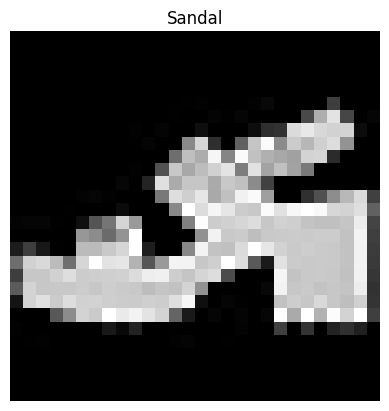

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray"),
plt.title(class_names[test_labels[0]])
plt.axis(False)

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model,
                              data=test_samples)

# View the first two pred probs
pred_probs[:2]

tensor([[3.8616e-10, 7.7953e-12, 1.0906e-10, 1.3688e-12, 1.5076e-10, 9.9999e-01,
         1.6923e-09, 4.2404e-08, 2.2686e-08, 8.9827e-06],
        [1.6048e-05, 9.9988e-01, 3.4170e-07, 1.5211e-05, 3.9442e-05, 1.0460e-07,
         5.3085e-05, 7.5218e-09, 6.7304e-09, 5.5828e-09]])

In [ ]:
# Convert prediction probs to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 6, 4, 7, 1])

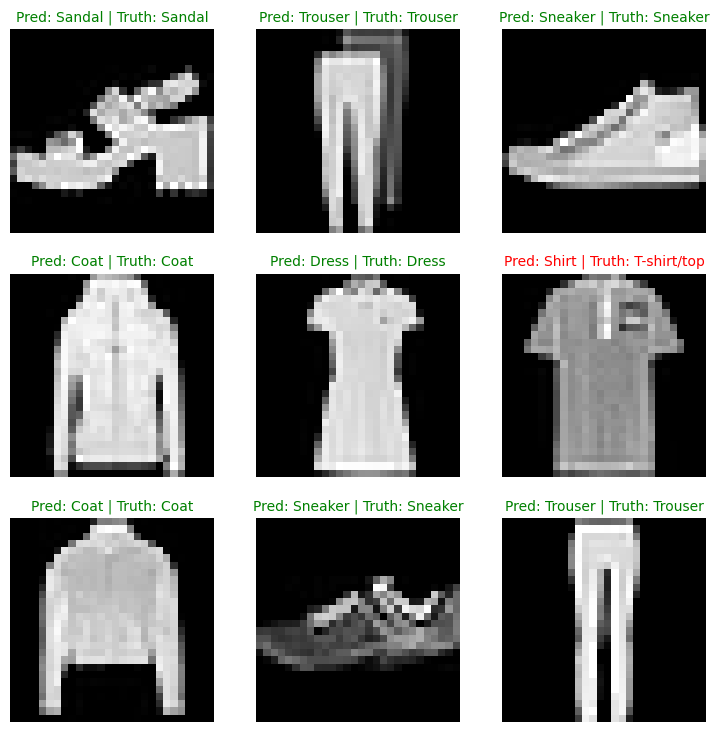

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot for each sample
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form)
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)

### Plot Confusion Matrix

In [ ]:
!pip install -q torchmetrics -U mlxtend
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [ ]:
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send data and targets to target device 
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_logit = model(X)
    # Turn predictions from logits to pred probs to pred labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

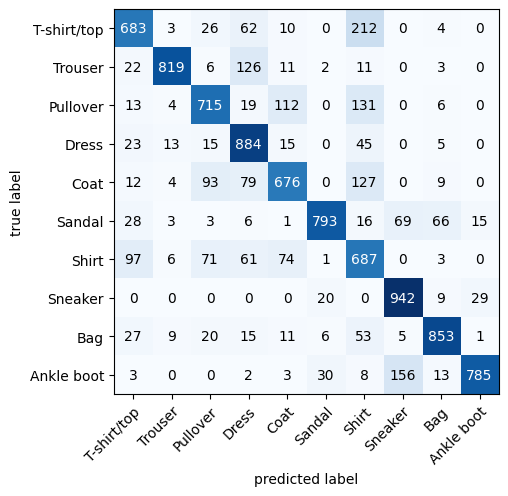

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_preds_tensor, target=test_data.targets)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(7, 5)
)